<a href="https://colab.research.google.com/github/pkolachi/geodist2typfeat/blob/master/exptnbs/sigtyp-st2020-part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60
%matplotlib inline
%pylab

import os.path 
import sys 
fpurl = os.path.join(
                     os.path.dirname(os.path.realpath(sys.argv[0])), 
                     '../taskrepo/data/train.csv'
                    )
if not os.path.isfile(fpurl):
  fpurl = 'https://raw.githubusercontent.com/sigtyp/ST2020/master/data/train.csv'

# the header from the csv is not properly tab-seperated. hence hard-coding
header = ['wals_code', 'name', 
          'latitude', 'longitude', 
          'genus', 'family', 'countrycodes', 
          'features'
         ]

CVFOLDS = 2   # default: 2 folds
REPEAT = 2

N = 100        # default: use all samples 
K = 10         # default: use only 5 feature classes

# turn this on iff running from command-line to test performance across 
# different values for (CVFOLDS, K, REPEAT) 
BATCH = False  

import itertools as it
from collections import Counter, defaultdict
from operator    import itemgetter
from IPython.display import display as pd_displayHTML

Autosaving every 60 seconds
Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [0]:
#%pip install -q pycodestyle_magic flake8
#%load_ext pycodestyle_magic

In [0]:
#%flake8_on -m 119 --ignore=E111

I hoped the provided train/test dataset is CSV compliant so that loading the dataset is as simple as using *pandas.read_csv*. It turned out not to be the case. The problem is with the header in the provided csv file, which makes inferring the columns using *header=auto* impossible. This is easily handled by hard-coding the column names in the header and skipping the first row when using *pandas.read_csv*.

In [4]:
%pip install -q --user pandas==1.0.3
import pandas as pd
df = pd.read_csv(fpurl, sep='\t', header=None, names=header,
                 #index_col=0,
                 error_bad_lines=True, skiprows=[0])
"""
# since this pynb will never be run on the held-out test set
if CVFOLDS <= 1:
  trnS, tstS = 0, 0   # dummy values for sizes of train and test partitions
else:
  tstdf = pd.read_csv(tstfpurl, sep='\t', header=None, names=header,
                      error_bad_lines=True, skiprows=[0])
  trnS, tstS = df.shape[0], tstdf.shape[0]
  df.append(tstdf)
"""
missingVal, missingLbl = '*-missing-*', '*-unknown-*'
featsFull = df.iloc[:, 0:-1]
clablFull = df.iloc[:, -1]
alablInst = Counter(albl for inst in clablFull for albl in inst.split('|'))
alablTabl = pd.DataFrame([{'name': n, 'id': i, 'freq': f}
                          for i,(n,f) in enumerate(alablInst.most_common(), 
                                                   start=1)
                         ]).set_index('name')
alablFull = pd.DataFrame([dict(albl.split('=', 1) for albl in inst.split('|'))
                          for inst in clablFull
                         ]).fillna(missingLbl) # fill missing values (no NaN) 
for incol in ['wals_code', 'name', 'genus', 'family', 'countrycodes']:
  featsFull[incol] = featsFull[incol].astype('category')
clablFull = clablFull.astype('category')
alablFull = alablFull.astype('category')

print(featsFull.shape, clablFull.shape, alablFull.shape, alablTabl.shape)

(1125, 7) (1125,) (1125, 185) (973, 2)


### Visualizing the dataset

Let us visualize a few statistics about the dataset 
1.   Histogram of the complex labels in the dataset
2.   Histogram of the atomic labels for each feature class in the dataset
3.   Scatterplots of genus vs labels, family vs labels and countrycodes vs labels

In [5]:
%pip install -q --user seaborn==0.10.0
import seaborn as sns
def plot_datastats(features, clabels, alabels):
  return

if not BATCH:
  plot_datastats(featsFull, clablFull, alablFull)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Adding features

##### Ideas:
+    Convert latitude and longitude to UTM which can be encoded as a discrete feature
    -  [wiki description](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) 
    -  [source code](https://github.com/Turbo87/utm) to use 
    - [kaggle question](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/discussion/62711) on similar topic 

The dataset is loaded into a DataFrame and seperated into two parts: input features and output labels. 

We know a few things about the input features like what are categorical features and what are numerical features. So, we encode the different columns in the feats DataFrame accordingly. *Hopefully this matters* when training different classifiers (especially thinking of decision trees). 

At this point, I'm not looking at best encoding scheme for the labels which are composite labels themselves (more on this later). The training dataset provided has 1109 unique labels for the dataset of 1125 languages. This indicates that there is *an optimal representation* for the label set.

### Sampling

In [6]:
# sub-select data frame to speed-up experiments while debugging
import random
# because we want sampling without replacement when we work with selected
# features classes to test, using random makes statistics across runs
# incomparable -- so use a uniform distribution to select feature classes for
# comparison across different experiments.
# to get robust estimates while testing, use random selection
if N < 2 or N > featsFull.shape[0]:
  subsid = list(range(featsFull.shape[0]))
else:
  subsid = list(range(0, featsFull.shape[0], featsFull.shape[0]//N))[:N]

if K < 0 or K > alablFull.shape[1]:
  subfci = list(range(alablFull.shape[1]))
else:
  subfci = list(sorted(random.sample(range(alablFull.shape[1]), K)))
  subfci = list(range(0, alablFull.shape[1], alablFull.shape[1]//K))[:K])
subfcs = list(alablFull.columns[i] for i in subfci)

#relevfeats = [i for i,f in enumerate(header)][2:-1]
featsFull_ = featsFull.iloc[subsid, :]
clablFull_ = clablFull.iloc[subsid]
alablSub_  = alablFull.iloc[subsid, subfci]
alablFull_ = alablFull.iloc[subsid, :]

print(featsFull_.shape, clablFull_.shape, alablFull_.shape, alablSub_.shape)

(100, 7) (100,) (100, 185) (100, 10)


### Input representations and Output encodings


Let us try a few classifiers using *scikit-learn* at this point. 

For what it is worth, the accuracies can be worse than a coin flip, considering the sparse label set.


 features of languages spoken in close proximity and belonging to the same family should be highly informative in predicting the typographical features for a new language. 

In [0]:
deprecated = """
# it is essential to make deep copies of the frame when building numpy
# matrices used for classification experiments.
# if not, changes to the matrix representations e.g. encoding categorial
# variables as ordinals or sparse-matrices are reflected in the original frame
# which results in errors when trying to re-use the frames for other experiments
# e.g. lookup in the atomic-label table built above results in errors because
# the lookup tries to find fnc=lbl-idx where idx is the category code
X   = featsFull_.copy(deep=False)
ccs = X.select_dtypes(['category']).columns
X[ccs] = X[ccs].apply(lambda x: x.cat.codes)

Y = clablFull_.copy(deep=False).cat.codes

Y_  = alablFull_.copy(deep=False)
ccs = Y_.select_dtypes(['category']).columns
Y_[ccs] = Y_[ccs].apply(lambda x: x.cat.codes)

subY_ = alablSub_.copy(deep=False)
ccs = subY_.select_dtypes(['category']).columns
subY_[ccs] = subY_[ccs].apply(lambda x: x.cat.codes)

X  = X.to_numpy()
Y  = Y.to_numpy()
Y_ = Y_.to_numpy()
subY_ = subY_.to_numpy()

print(X.shape, Y.shape, Y_.shape, subY_.shape)
""";

In [8]:
 %pip install -q --user scikit-learn==0.22.2.post1
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder 

lblenc = LabelEncoder().fit(clablFull_)
Ynms   = lblenc.classes_
Y      = lblenc.transform(clablFull_)

lblenc = OrdinalEncoder().fit(alablFull_)
aYnms  = lblenc.categories_
Y_     = lblenc.transform(alablFull_)

mlablFull = [[alablTabl.loc['{0}={1}'.format(fcn, lbl),'id']
              for fcn,lbl in row.items() if lbl != missingLbl]
             for row in alablFull_.to_dict(orient='records')
            ]
Ymlbl = MultiLabelBinarizer().fit_transform(mlablFull)

rawX = featsFull_.copy(deep=False)

print(Y.shape, Y_.shape, Ymlbl.shape)

(100,) (100, 185) (100, 582)


In [9]:
if len(subfci) < alablFull_.shape[1]:
  clablSub = ['|'.join('{0}={1}'.format(fcn, lbl) for fcn, lbl in row.items()
                       if lbl != missingLbl)
              for row in alablSub_.to_dict(orient='records')
             ]
  lblenc   = LabelEncoder().fit(clablSub)
  subYnms  = lblenc.classes_
  subY     = lblenc.transform(clablSub)

  lblenc   = OrdinalEncoder().fit(alablSub_)
  subaYnms = lblenc.categories_
  subY_    = lblenc.transform(alablSub_)
  
  mlablSub = [[alablTabl.loc['{0}={1}'.format(fcn, lbl),'id']
               for fcn,lbl in row.items() if lbl != missingLbl]
              for row in alablSub_.to_dict(orient='records')
             ]
  subYmlbl = MultiLabelBinarizer().fit_transform(mlablSub)
else:
  subY, subY_, subYmlbl = Y, Y_, Ymlbl

print(subY.shape, subY_.shape, subYmlbl.shape)

(100,) (100, 10) (100, 28)


In [0]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# https://scikit-learn.org/stable/modules/cross_validation.html
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

from sklearn import pipeline as skpipe
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder 

numfxr = SimpleImputer(strategy='median')
strfxr = SimpleImputer(strategy='constant', fill_value=missingVal)
strfx_ = SimpleImputer(strategy='most_frequent')

ordtrn = OrdinalEncoder(categories='auto')
fohtrn = OneHotEncoder(handle_unknown='ignore', sparse=False)
sohtrn = OneHotEncoder(handle_unknown='ignore', sparse=True)

stdtrn = StandardScaler()

# Dimensionality reduction techniques 
opca = PCA(svd_solver='arpack', random_state=20200408)
osvd = TruncatedSVD(algorithm='arpack', random_state=20200408)

# numerical and categorial features in the given data
numfeats = ['latitude', 'longitude']
catfeats = ['wals_code', 'name', 'genus', 'family', 'countrycodes'] 

# for numerical features, fill unknown feature values with median value and 
# scale the column with mean and variance
numtrans = skpipe.Pipeline(steps=[('imputer', numfxr), ('scale',  stdtrn)])

# for categorial features, try both one-hot encoding and ordinal encoding
ohcattrans = skpipe.Pipeline(steps=[('imputer', strfxr), ('transform', fohtrn)])
oecattrans = skpipe.Pipeline(steps=[('imputer', strfxr), ('transform', ordtrn)])

cohtrans = ColumnTransformer(transformers=[('num', numtrans, numfeats), 
                                           ('cat', ohcattrans, catfeats)])
coetrans = ColumnTransformer(transformers=[('num', numtrans, numfeats), 
                                           ('cat', oecattrans, catfeats)])
# There are known issues in sklearn when integrating OrdinalFeatures into the 
# pipeline that cause problems with the standard/usual way of incorporating a 
# transformer to extract features. 
# Below is a 'hacky' version that gets around this and simulates the use of 
# dense numerical features for this classification task -- note that, this is
# still a hack
uniqcats = [rawX.loc[:,catn].unique() for catn in catfeats]
oetrans_ = skpipe.Pipeline(steps=[('imputer', strfx_),
                           ('transform', OrdinalEncoder(categories=uniqcats))])
altoetrn = ColumnTransformer(transformers=[('num', numtrans, numfeats), 
                                           ('cat', oetrans_, catfeats)])

# There is a third possibility -- one-hot encoding of each categorial feature
# followed by a svd. This results in a dense representation of each categorial
# feature -- defined by the dim of svd
ohtrans_ = skpipe.Pipeline(steps=[('imputer', strfxr), ('transform', sohtrn), 
                                  ('compress', osvd), ('scale', stdtrn)])
altohtrn = ColumnTransformer(transformers=[('num', numtrans, numfeats), 
                                           ('cat', ohtrans_, catfeats)])

preprocessors = {'ohe': cohtrans,
                #'ord': coetrans,
                 'ord': altoetrn,
                 'ohd': altohtrn,
                }

npca = skpipe.Pipeline(steps=[('dimred', opca), ('dimscale', stdtrn)])
nsvd = skpipe.Pipeline(steps=[('dimred', osvd), ('dimscale', stdtrn)])

featreprtrans = {'dim0': 'passthrough', 
                 'pca':  opca, 
                 'svd':  osvd, 
                 'npca': npca, 
                 'nsvd': nsvd
                }

### Multi-class classification

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

# all these classifiers support multi-class classification in sklearn
mclsclfnms = ['knn', 'lsvm', 'svc', 'mlp', 'dt', 
              'rf', 'adb', 
              'nb', 'ridge', 'dumbase',
             #'gp', 'qda', 
             ]
mclsclfobj = [KNeighborsClassifier(p=1), # works well for all inputs 
              LinearSVC(penalty='l1', dual=False, C=0.01, random_state=20200408),
              SVC(gamma=2, random_state=20200408),
              MLPClassifier(activation='logistic', solver='adam', alpha=10, 
                            early_stopping=False, max_iter=1000,
                            random_state=20200408),
              DecisionTreeClassifier(max_features='auto', ccp_alpha=0.1, 
                                     random_state=20200408),
              RandomForestClassifier(n_estimators=10, criterion='entropy', 
                                     ccp_alpha=0.1, random_state=20200408),
              AdaBoostClassifier(random_state=20200408),
              GaussianNB(),
              RidgeClassifier(random_state=20200408),
              DummyClassifier(strategy="most_frequent"),
             #GaussianProcessClassifier(),
             #QuadraticDiscriminantAnalysis(),
             ]
mclsclfopt = dict(zip(mclsclfnms, mclsclfobj))

# setup pipelines for all combination of preprocessors and classifiers
pipelines  = {(clf, enc, dim):
               skpipe.make_pipeline(preprocessors[enc], featreprtrans[dim],
                                    mclsclfopt[clf])
              for (clf, enc, dim) in it.product(mclsclfopt, preprocessors, 
                                                featreprtrans)
             }
pipelines  = dict(sorted(pipelines.items()))

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
REPEAT  = REPEAT  if REPEAT  >  1 else 1  # sanity-check
CVFOLDS = CVFOLDS if CVFOLDS >= 2 else 2  # sanity-check
# scikit-learn documentation recommends using StratifiedKFold for classification
# problems to preserve class balance across folds. however, in this case, 
# we use KFold and RepeatedKFold because 
#  number of items in a class <= CVFOLDS (works only with 2 folds for entire dataset)
#  there is not much balance to preserve w.r.t. complex labels
cvsplits = list(RepeatedKFold(n_splits=CVFOLDS, 
                              n_repeats=REPEAT, random_state=20200408
                             ).split(rawX, Y))

statnames = ['classifier', 
             'avg.acc/tst', 'avg.acc/trn', 'std.acc/tst', 'std.acc/trn', 
             'avg.time/prd', 'avg.time/trn'] 
statcodes = ['clfn', 'mtsts', 'mtrns', 'vtsts', 'vtrns', 'predt', 'trint']

# https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=DeprecationWarning)
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter(action='always', category=ConvergenceWarning)
simplefilter(action='always', category=FitFailedWarning)

In [0]:
# DummyClassifier is invariant of the input representation
dmbcmbs = [_ for _ in pipelines if _[0] == 'dumbase' and 
                                   _ != ('dumbase', 'ohe', 'dim0')]
for cmb in dmbcmbs: del pipelines[cmb]
# DecisionTrees are invariant of the input representation
# I don't understand why though just yet .. 
dmbcmbs = [_ for _ in pipelines if _[0] == 'dt' and 
                                   _ != ('dt', 'ohe', 'dim0')]
for cmb in dmbcmbs: del pipelines[cmb]
# Experiments show that plain pca and svd are inferior compared to the 
# normalized variants
dmbcmbs = [_ for _ in pipelines if _[2] in ['pca', 'svd']]
for cmb in dmbcmbs: del pipelines[cmb]

In [0]:
def plot_accuracies(accuracies, savefile=None):
  hastime = 'avg.time/prd' in accuracies.columns and 'avg.time/trn' in accuracies.columns

  accuracies_ = accuracies.iloc[::-1]
  nrs, ncs = 1, 4
  o, r, m, n = tuple(range(4))
  lefts = [0 for _ in range(accuracies.shape[0])]
  fig, axs = plt.subplots(nrs, ncs, sharey=True, sharex='col', 
                         squeeze=False, 
                         figsize=(6.4, 0.25*accuracies.shape[0]))
  axs[o//ncs][o%ncs].barh(accuracies_['classifier'], accuracies_['avg.acc/tst'], 
                          left=lefts, 
                          xerr=accuracies_['std.acc/tst'])
  axs[o//ncs][o%ncs].text(.5, .98, 'held-out', horizontalalignment='center', 
                          transform=axs[o//ncs][o%ncs].transAxes)
  axs[r//ncs][r%ncs].barh(accuracies_['classifier'], accuracies_['avg.acc/trn'], 
                          left=lefts, 
                          xerr=accuracies_['std.acc/trn'])
  axs[r//ncs][r%ncs].text(.5, .98, 'training', horizontalalignment='center', 
                          transform=axs[r//ncs][r%ncs].transAxes)
  if hastime:
    axs[m//ncs][m%ncs].barh(accuracies_['classifier'], accuracies_['avg.time/prd'], 
                            left=lefts)
    axs[m//ncs][m%ncs].text(.5, .98, 'prediction', horizontalalignment='center', 
                            transform=axs[m//ncs][m%ncs].transAxes)
    axs[n//ncs][n%ncs].barh(accuracies_['classifier'], accuracies_['avg.time/trn'], 
                            left=lefts)
    axs[n//ncs][n%ncs].text(.5, .98, 'training', horizontalalignment='center', 
                            transform=axs[n//ncs][n%ncs].transAxes)
  axs[o//ncs][o%ncs].set_xlabel('Accuracy')
  axs[r//ncs][r%ncs].set_xlabel('Accuracy')
  axs[m//ncs][m%ncs].set_xlabel('Time(s)')
  axs[n//ncs][n%ncs].set_xlabel('Time(s)')
  # minimize space between subplots
  plt.subplots_adjust(hspace=0)

  if not savefile:
    #plt.show()
    pass
  else:
    plt.savefig(savefile)
  return

CPU times: user 25.8 s, sys: 6.6 s, total: 32.4 s
Wall time: 24.5 s


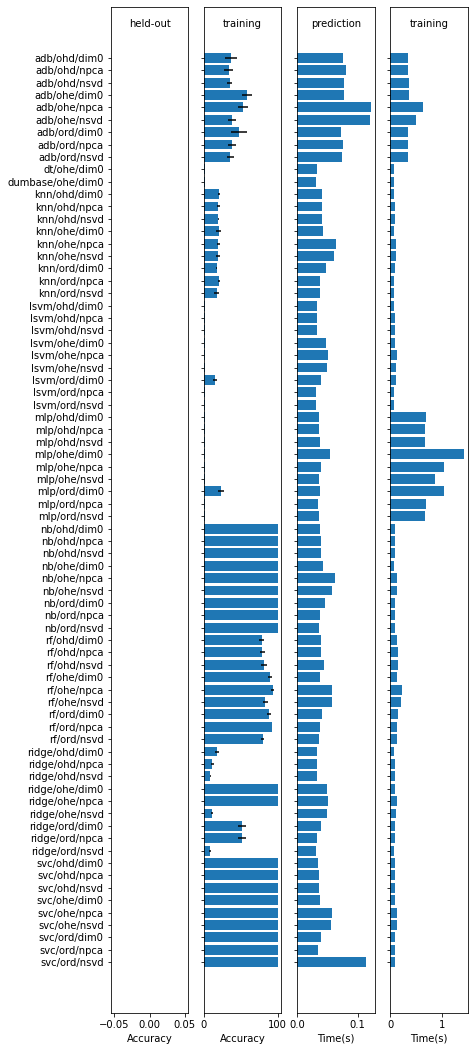

In [14]:
from sklearn import model_selection as skms

codify_classifier = lambda clf: '/'.join(clf) if isinstance(clf, 
                                              (list, tuple, set)) else str(clf) 
select_nclfcombos = lambda df, n: df.sort_values(by=['avg.acc/tst', 
                                                     'avg.acc/trn'], 
                                          ascending=False).groupby(lambda rid: 
 df.loc[rid, 'classifier'].split('/')[0]).head(n).sort_values(by=['classifier'])
select_clfcombos  = lambda df: select_nclfcombos(df, 1)

def trainFullClassifiersCV(classifiers, X, Y):
  clfaccs = []
  for iclf, nclf in enumerate(classifiers):
    clfsce = skms.cross_validate(classifiers[nclf], X, Y, cv=cvsplits, 
                                 return_train_score=True
                                )
    clfnfo = [codify_classifier(nclf), 
              100*clfsce['test_score'].mean(), 100*clfsce['train_score'].mean(),
              100*clfsce['test_score'].std(),  100*clfsce['train_score'].std(),
              clfsce['score_time'].sum(), clfsce['fit_time'].sum()
             ]
    clfaccs.append(dict(zip(statnames, clfnfo)))
  return pd.DataFrame(clfaccs)

%time clfaccs = trainFullClassifiersCV(pipelines, rawX, Y)
if not BATCH:
  clfaccs_ = clfaccs.dropna()
  plot_accuracies(clfaccs_)

CPU times: user 27 s, sys: 6.89 s, total: 33.9 s
Wall time: 25.6 s


classifier,avg.acc/tst,avg.acc/trn,std.acc/tst,std.acc/trn,avg.time/prd,avg.time/trn
adb/ohe/nsvd,22.500000,31.000000,4.974937,3.605551,0.102935,0.474383
dt/ohe/dim0,25.000000,25.000000,3.605551,3.605551,0.031689,0.066501
dumbase/ohe/dim0,25.000000,25.000000,3.605551,3.605551,0.030931,0.067605
knn/ohd/dim0,21.500000,29.000000,3.570714,2.236068,0.039765,0.077859
lsvm/ohd/dim0,25.000000,25.000000,3.605551,3.605551,0.032789,0.078679
mlp/ohd/dim0,25.000000,25.000000,3.605551,3.605551,0.037068,0.851799
nb/ohe/nsvd,19.000000,75.000000,4.358899,5.196152,0.056236,0.118664
rf/ohe/dim0,18.500000,78.500000,2.958040,4.330127,0.038351,0.123800
ridge/ohd/nsvd,25.500000,25.000000,3.570714,3.605551,0.033539,0.089680
svc/ohe/dim0,25.000000,100.000000,3.605551,0.000000,0.036541,0.083571


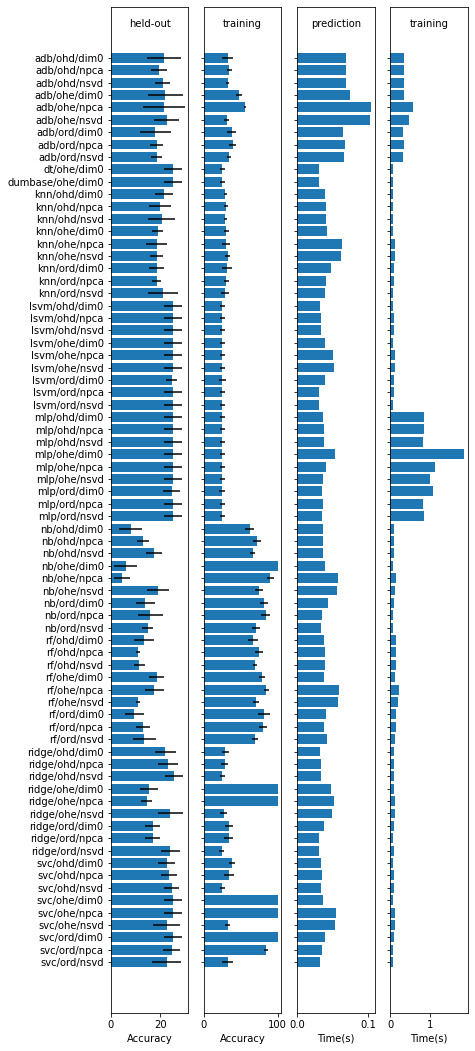

In [15]:
%time sclfaccs = trainFullClassifiersCV(pipelines, rawX, subY)
if not BATCH:
  sclfaccs_ = sclfaccs.dropna()
  #print(select_clfcombos(sclfaccs_).round(3).to_markdown(showindex=False))
  pd_displayHTML(select_clfcombos(sclfaccs_).style.hide_index())
  plot_accuracies(sclfaccs_)

### Multi-label Classification


In [0]:
mlblclfnms = ['1knn', '2knn', 'mlp', 'dt', 'rf', 'dumbase']
mlblclfobj = [KNeighborsClassifier(p=1), # Manhattan distance
              KNeighborsClassifier(p=2), # Euclidean distance
              MLPClassifier(activation='logistic', solver='lbfgs', alpha=10, 
                           early_stopping=True, max_iter=1000,
                           random_state=20200408),
# optimized to reduce overfitting; good accuracy on small feature subsets; 
# terrible accuracy on full dataset; doesn't reduce train/test time
# full hyper-parameter tuning needs to be carried out
              DecisionTreeClassifier(ccp_alpha=0.1, random_state=20200408), 
              RandomForestClassifier(n_estimators=10, ccp_alpha=0.1, 
                                    random_state=20200408),
              DummyClassifier(strategy='most_frequent')
             ]
mlblclfopt = dict(zip(mlblclfnms, mlblclfobj))
mlblclfpls = {(clf, enc, dim):
               skpipe.make_pipeline(preprocessors[enc], featreprtrans[dim],
                                    mlblclfopt[clf])
              for (clf, enc, dim) in it.product(mlblclfopt, preprocessors, 
                                                featreprtrans)
             }
mlblclfpls = dict(sorted(mlblclfpls.items()))

In [0]:
# DummyClassifier is invariant of the input representation
dmbcmbs = [_ for _ in mlblclfpls if _[0] == 'dumbase' and 
                                    _ != ('dumbase', 'ohe', 'dim0')]
for cmb in dmbcmbs: del mlblclfpls[cmb]
# DecisionTrees are invariant of the input representation
# I don't understand why though just yet .. 
dmbcmbs = [_ for _ in mlblclfpls if _[0] == 'dt' and 
                                    _ != ('dt', 'ohe', 'dim0')]
for cmb in dmbcmbs: del mlblclfpls[cmb]
# Experiments show that plain pca and svd are inferior compared to the 
# normalized variants
dmbcmbs = [_ for _ in mlblclfpls if _[2] in ['pca', 'svd']]
for cmb in dmbcmbs: del mlblclfpls[cmb]

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

CPU times: user 27.5 s, sys: 6.03 s, total: 33.6 s
Wall time: 26.2 s


classifier,avg.acc/tst,avg.acc/trn,std.acc/tst,std.acc/trn,avg.time/prd,avg.time/trn
1knn/ord/nsvd,19.000000,22.500000,5.385165,3.570714,0.184232,0.082796
2knn/ord/nsvd,19.000000,24.500000,4.123106,2.598076,0.180422,0.079886
dt/ohe/dim0,25.000000,25.000000,3.605551,3.605551,0.034708,0.087174
dumbase/ohe/dim0,25.000000,25.000000,3.605551,3.605551,0.033490,0.065351
mlp/ohd/dim0,25.000000,25.000000,3.605551,3.605551,0.039338,0.676481
rf/ohd/dim0,25.000000,25.000000,3.605551,3.605551,0.055776,0.159478


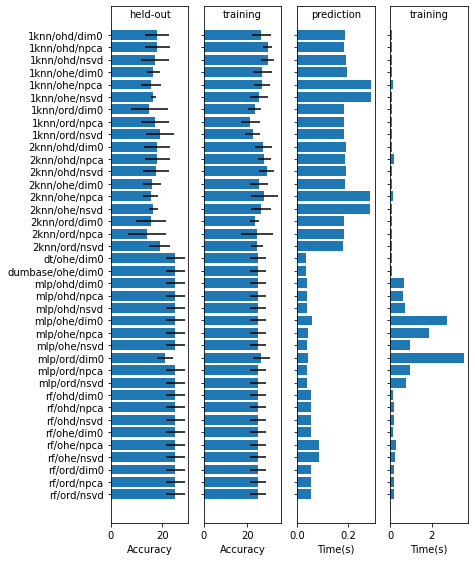

In [18]:
%time smlblclfacc = trainFullClassifiersCV(mlblclfpls, rawX, subYmlbl)
if not BATCH:
  smlblclfacc_ = smlblclfacc.dropna()
  pd_displayHTML(select_clfcombos(smlblclfacc_).style.hide_index())
  plot_accuracies(smlblclfacc_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

CPU times: user 7min 44s, sys: 3min 22s, total: 11min 6s
Wall time: 6min 38s


classifier,avg.acc/tst,avg.acc/trn,std.acc/tst,std.acc/trn,avg.time/prd,avg.time/trn
1knn/ohd/dim0,0.000000,0.000000,0.000000,0.000000,3.127398,0.124806
2knn/ohd/dim0,0.000000,0.000000,0.000000,0.000000,3.095255,0.121747
dt/ohe/dim0,0.000000,0.000000,0.000000,0.000000,0.059699,0.374985
dumbase/ohe/dim0,0.000000,0.000000,0.000000,0.000000,0.043148,0.123271
mlp/ohd/dim0,0.000000,0.000000,0.000000,0.000000,0.071722,23.169182
rf/ohd/dim0,0.000000,0.000000,0.000000,0.000000,0.340588,0.827798


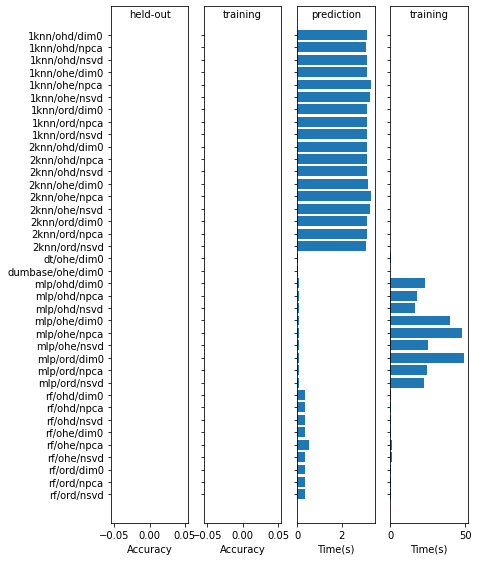

In [19]:
%time mlblclfacc = trainFullClassifiersCV(mlblclfpls, rawX, Ymlbl)
if not BATCH:
  mlblclfacc_ = mlblclfacc.dropna()
  pd_displayHTML(select_clfcombos(mlblclfacc_).style.hide_index())
  plot_accuracies(mlblclfacc_)

### Multi-label Multi-class Classification

In [0]:
from sklearn import model_selection as skms
from sklearn import metrics as skmt
from sklearn.exceptions import NotFittedError

def skmt_mlmc_accuracy_score(y_true, y_pred):
  "Classification accuracy for multi-label multi-class problems"
  n_samples = y_true.shape[0]
  return sum(1.0 if np.array_equal(y_true[i], y_pred[i]) else 0
             for i in range(n_samples)
            ) / n_samples

def trainIndClassifiersCV(classifiers, X, matY, return_clfinsts=False):
  lclfinst  = {}  # table to store classifiers for later use
  lclfaccs = np.zeros((matY.shape[-1], len(classifiers), 6))
  avgcaccs = []
  for iclf, nclf in enumerate(classifiers):
    try:
      for indY in range(matY.shape[-1]):
        clfsce = skms.cross_validate(classifiers[nclf], X, matY[:,indY], 
                                     cv=cvsplits, 
                                     return_train_score=True, 
                                     return_estimator=return_clfinsts
                                    )
        lclfaccs[indY][iclf] = [100*clfsce['test_score'].mean(), 
                                100*clfsce['train_score'].mean(), 
                                100*clfsce['test_score'].std(),  
                                100*clfsce['train_score'].std(), 
                                clfsce['score_time'].sum(), 
                                clfsce['fit_time'].sum()
                               ]
        if return_clfinsts:
          lclfinst[(nclf, indY)] = clfsce['estimator']
    except FitFailedWarning:
      # remove all instances of estimators for this classifier setup
      for fclf in (_ for _ in lclfinst if _[0] == nclf):
        del lclfinst[fclf] 
    clfnfo = [codify_classifier(nclf), 
              lclfaccs[:,iclf,0].mean(), lclfaccs[:,iclf,1].mean(),
              lclfaccs[:,iclf,2].mean(), lclfaccs[:,iclf,3].mean(),
              lclfaccs[:,iclf,4].sum(),  lclfaccs[:,iclf,5].sum()
             ]
    avgcaccs.append(dict(zip(statnames, clfnfo)))
  if return_clfinsts:
    return (pd.DataFrame(avgcaccs), lclfinst)
  else:
    return pd.DataFrame(avgcaccs)

def jntTestIndClassifiersCV(classifiers, X, matY, clfinstances=None):
  if not clfinstances:
    _, clfinstances = trainIndClassifiersCV(classifiers, X, matY, return_clfinsts=True)
  trnpids = list(map(itemgetter(0), cvsplits))
  tstpids = list(map(itemgetter(1), cvsplits))
  # list of classifiers that were fitted successfully in the previous experiment
  clfnames = sorted(set(x[0] for x in clfinstances))
  jclfaccs = []
  
  for iclf, nclf in enumerate(clfnames):
    try:
      # when passing the numerical matrix directly to the classifier
      _predsst = lambda clf,sids: clf.predict(X[sids,:]).reshape((-1, 1))
      # we are now handling the DataFrame directly using pipelines
      predsst = lambda clf, sids: clf.predict(X.iloc[sids,:]).reshape((-1, 1))
      tstpreds, trnpreds = [], []
      for cvid, (trnids,tstids) in enumerate(cvsplits):
        indpreds = list(it.starmap(predsst, [(clfinstances[nclf, indY][cvid], 
                                                tstids)
                                           for indY in range(matY.shape[-1])]))
        tstpreds.append(np.hstack(indpreds))
        indpreds = list(it.starmap(predsst, [(clfinstances[nclf, indY][cvid], 
                                                trnids)
                                           for indY in range(matY.shape[-1])]))
        trnpreds.append(np.hstack(indpreds))
        
      tstaccs = 100*np.array([skmt_mlmc_accuracy_score(matY[sids], preds) 
                                    for sids, preds in zip(tstpids, tstpreds)])
      trnaccs = 100*np.array([skmt_mlmc_accuracy_score(matY[sids], preds)
                                    for sids, preds in zip(trnpids, trnpreds)])
      clfnfo = [codify_classifier(nclf), 
                  tstaccs.mean(), trnaccs.mean(), tstaccs.std(), trnaccs.std()]
      jclfaccs.append(dict(zip(statnames, clfnfo)))
    except (NotFittedError, AttributeError) as err:
      pass
  return pd.DataFrame(jclfaccs)

CPU times: user 4min 21s, sys: 1min 4s, total: 5min 25s
Wall time: 4min 7s


classifier,avg.acc/tst,avg.acc/trn,std.acc/tst,std.acc/trn,avg.time/prd,avg.time/trn
adb/ohe/npca,79.600000,89.500000,4.413532,3.916295,0.906522,5.371361
dt/ohe/dim0,80.750000,81.350000,3.875181,3.726084,0.314075,0.663776
dumbase/ohe/dim0,80.750000,81.350000,3.875181,3.726084,0.311046,0.638398
knn/ohd/dim0,80.550000,82.650000,3.833461,3.728232,0.409721,0.797083
lsvm/ohd/dim0,81.200000,81.200000,3.898212,3.898212,0.335394,0.798565
mlp/ohd/dim0,80.750000,81.350000,3.875181,3.726084,0.368340,8.295141
nb/ohe/nsvd,79.850000,83.550000,3.666341,3.691831,0.508156,1.153923
rf/ohe/dim0,80.650000,87.200000,3.619508,3.469825,0.376294,1.184854
ridge/ohd/nsvd,80.850000,81.650000,3.970488,3.987703,0.333095,0.897743
svc/ohe/dim0,80.750000,100.000000,3.875181,0.000000,0.363029,0.731265


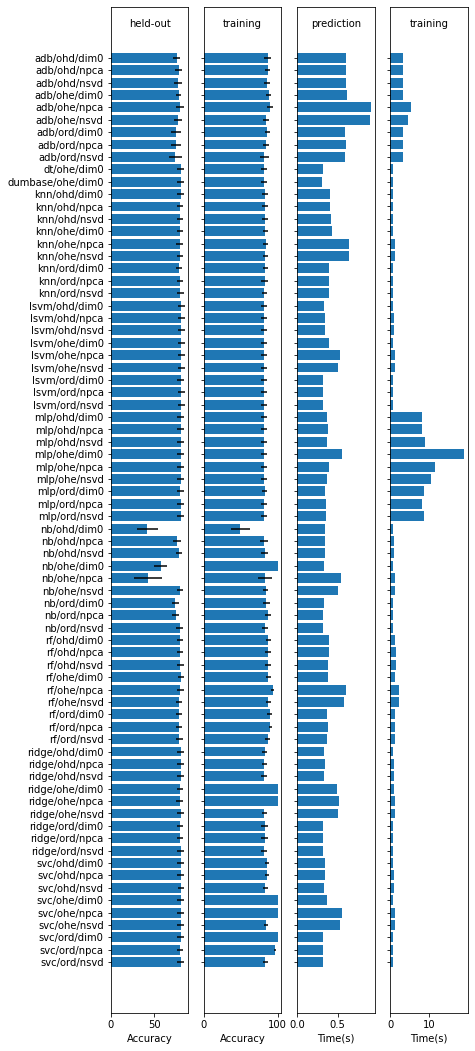

In [21]:
%time avgcaccs, lclclfs = trainIndClassifiersCV(pipelines, rawX, subY_, return_clfinsts=True)
if not BATCH:
  avgcaccs_ = avgcaccs.dropna()
  pd_displayHTML(select_clfcombos(avgcaccs_).style.hide_index())
  plot_accuracies(avgcaccs_)  

CPU times: user 1min 7s, sys: 12.4 s, total: 1min 19s
Wall time: 1min 5s


classifier,avg.acc/tst,avg.acc/trn,std.acc/tst,std.acc/trn
adb/ohd/npca,17.000000,31.000000,3.316625,2.236068
dt/ohe/dim0,21.000000,21.500000,8.306624,6.538348
dumbase/ohe/dim0,21.000000,21.500000,8.306624,6.538348
knn/ohd/dim0,16.000000,26.000000,5.830952,5.830952
lsvm/ohd/dim0,25.000000,25.000000,3.605551,3.605551
mlp/ohd/dim0,21.000000,21.500000,8.306624,6.538348
nb/ord/nsvd,16.500000,23.000000,5.894913,4.358899
rf/ohe/dim0,19.500000,38.000000,8.529361,7.071068
ridge/ohd/nsvd,21.000000,22.000000,8.306624,6.782330
svc/ohe/dim0,21.000000,100.000000,8.306624,0.000000


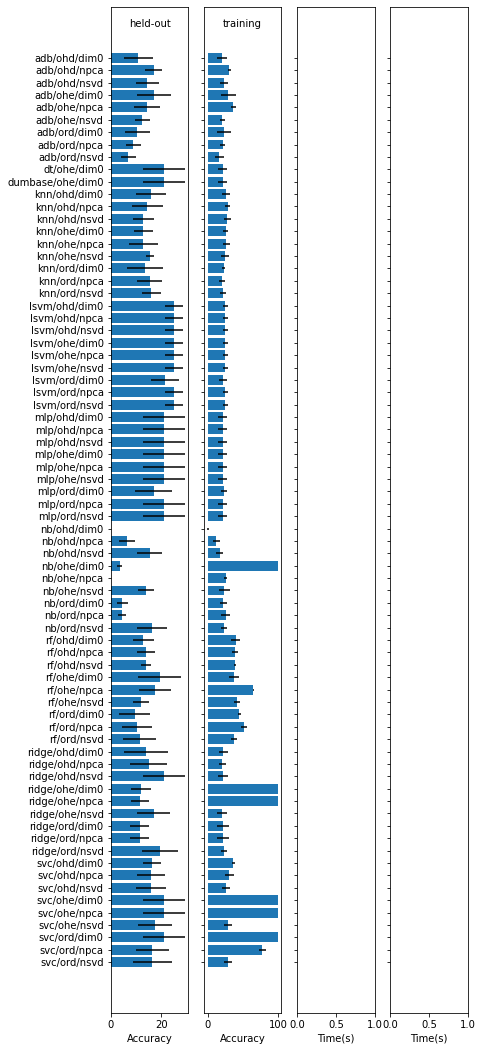

In [22]:
%time jclfaccs = jntTestIndClassifiersCV(pipelines, rawX, subY_, clfinstances=lclclfs)
if not BATCH:
  jclfaccs_ = jclfaccs.dropna()
  pd_displayHTML(select_clfcombos(jclfaccs_).style.hide_index())
  plot_accuracies(jclfaccs_)


TODO: 

*   also pick an optimal encoding scheme
*   test some manual feature additions like geographic distances
*   also check l1 regularization and see which features matter the most

### Hyperparameter Tuning



In [0]:
paramsKNN = {
 'kneighborsclassifier__n_neighbors': range(3, 11), 
 'kneighborsclassifier__weights': ('uniform', 'distance'),
 'kneighborsclassifier__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
 'kneighborsclassifier__p': (1, 2), 
}
paramsSVL = {
 'linearsvc__penalty': ('l1', 'l2'),
 'linearsvc__loss': ('squared_hinge', 'hinge'), 
 'linearsvc__dual': (False, True), 
 #'linearsvc__tol',     
 'linearsvc__C': [i/100 for i in range(0, 25)],
 #'linearsvc__fit_intercept', 
 #'linearsvc__intercept_scaling', 
 'linearsvc__class_weight': (None, 'balanced'), 
 #'linearsvc__max_iter', 
}
paramsSVC = {
 'svc__C': 10**-np.arange(-1, 2.5, 0.35), 
 'svc__kernel': ('poly', 'rbf', 'sigmoid',), 
 'svc__degree': range(2, 5), 
 #'svc__gamma': np.arange(0, 4, 0.5), 
 #'svc__coef0', 
 #'svc__shrinking', 
 #'svc__tol', 
 'svc__class_weight': (None, 'balanced'), 
}
paramsMLP = {
 'mlpclassifier__hidden_layer_sizes':[(size,) for size in range(50, 60, 20)], 
 'mlpclassifier__activation':('logistic', 'relu', 'tanh'), 
 'mlpclassifier__solver':('adam', 'lbfgs'), 
 'mlpclassifier__alpha':[10.0**i for i in range(-7,4)], 
 'mlpclassifier__max_iter':range(200, 1001, 100),
 'mlpclassifier__early_stopping':(False, True),
}
paramsDT  = {
 'decisiontreeclassifier__criterion': ('gini', 'entropy'), 
 'decisiontreeclassifier__max_features': ('auto', 'sqrt', 'log2', None), 
 'decisiontreeclassifier__class_weight': (None, 'balanced'),
 'decisiontreeclassifier__ccp_alpha': [i/10 for i in range(0, 11)], 
 #'decisiontreeclassifier__max_depth':, 
 #'decisiontreeclassifier__max_leaf_nodes':, 
 #'decisiontreeclassifier__min_impurity_decrease',
 #'decisiontreeclassifier__min_impurity_split', 
 #'decisiontreeclassifier__min_samples_leaf', 
 #'decisiontreeclassifier__min_samples_split', 
 #'decisiontreeclassifier__min_weight_fraction_leaf', 
 #'decisiontreeclassifier__presort', 
 #'decisiontreeclassifier__random_state', 
 #'decisiontreeclassifier__splitter'
}
paramsRF  = {
 'randomforestclassifier__n_estimators': range(10, 200, 10),
 'randomforestclassifier__criterion': ('entropy', 'gini',),
 'randomforestclassifier__max_features': ('auto', 'sqrt', 'log2', None),
 'randomforestclassifier__bootstrap': (True, False),
 'randomforestclassifier__class_weight': (None, 'balanced'), 
 'randomforestclassifier__ccp_alpha': [i/10 for i in range(1, 2)],
 #'randomforestclassifier__max_depth', 
 #'randomforestclassifier__min_samples_split', 
 #'randomforestclassifier__min_samples_leaf', 
 #'randomforestclassifier__min_weight_fraction_leaf',
 #'randomforestclassifier__max_leaf_nodes', 
 #'randomforestclassifier__min_impurity_decrease', 
 #'randomforestclassifier__min_impurity_split', 
 #'randomforestclassifier__max_samples', 
}
paramsDummy = {
 'dummyclassifier__strategy': ('stratified', 'most_frequent', 'prior', 'uniform'),
 #'dummyclassifier__constant': (1,), 
 #'dummyclassifier__random_state', 
}

clfParams = {'knn': paramsKNN, '1knn': paramsKNN, '2knn': paramsKNN,
             'lsvm': paramsSVL, 'svc': paramsSVC,
             'dt': paramsDT, 'rf': paramsRF, 'mlp': paramsMLP,
             'dumbase': paramsDummy,
}
trnParams = {
 'columntransformer__cat__compress__algorithm': ('randomized', 'arpack'),
 'columntransformer__cat__compress__n_components': range(2, 53, 5),
 'columntransformer__cat__compress__n_iter': (3, 5, 7),
 'columntransformer__cat__compress__tol': (0.0, )
}
dimParams = {
 'pipeline__dimred__n_components': range(1, 7),
 'pipeline__dimred__svd_solver': ('arpack', 'auto', 'full', 'randomized', 'arpack'),
}

CLF = 'rf'
params = set([prm for pln in pipelines if pln[0] == CLF
               for prm in pipelines[pln].get_params() if prm.find('__') != -1
            ]) 
#print('\n'.join(sorted(params)))

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from functools import reduce 

#grdmclsclf = GridSearchCV(pipelines[clf], param_grid=paramsDummy,
#                          cv=cvsplits, n_jobs=2).fit(rawX, subY)
FRAC = 1
lzylength = lambda val: len(val) if hasattr(val, '__len__') else len(list(val))
paramcmbs = lambda cmb: reduce(lambda x,y: x*y, map(lzylength, cmb), 0)
cmnchoices = set()
for clf in (_ for _ in pipelines if _[0] == CLF):
  lchoices  = [(prm, trnParams[prm]) for prm in trnParams]
  lchoices += [(prm, dimParams[prm]) for prm in dimParams]
  clfparams = clfParams[clf[0]] if clf[0] in clfParams else {}
  lchoices += [(prm, clfparams[prm]) for prm in clfparams]
  lchoices  = {prm: val for prm, val in lchoices
                if prm in pipelines[clf].get_params()}
  itern = paramcmbs(lchoices.values())
  itern = int(FRAC*itern) if int(FRAC*itern) > 1 else 1 
  grdmclsclf = RandomizedSearchCV(pipelines[clf],
                                  param_distributions=lchoices, 
                                  n_iter=itern,
                                  cv=cvsplits, n_jobs=2).fit(rawX, subY)
  bstprmsstr = '|'.join("{0}={1}".format(pnme, pval)
                        for pnme, pval in grdmclsclf.best_params_.items())
  print(codify_classifier(clf), grdmclsclf.best_score_, bstprmsstr)
  if len(cmnchoices):
    cmnchoices = cmnchoices.intersection(grdmclsclf.best_params_.items())
  else:
    cmnchoices = set(grdmclsclf.best_params_.items())
  grdmclsres = pd.DataFrame(grdmclsclf.cv_results_)
print(cmnchoices)

rf/ohd/dim0 0.15999999999999998 randomforestclassifier__n_estimators=100|randomforestclassifier__max_features=log2|randomforestclassifier__criterion=entropy|randomforestclassifier__class_weight=None|randomforestclassifier__ccp_alpha=0.1|randomforestclassifier__bootstrap=False|columntransformer__cat__compress__tol=0.0|columntransformer__cat__compress__n_iter=7|columntransformer__cat__compress__n_components=12|columntransformer__cat__compress__algorithm=randomized
rf/ohd/npca 0.17 randomforestclassifier__n_estimators=30|randomforestclassifier__max_features=None|randomforestclassifier__criterion=entropy|randomforestclassifier__class_weight=None|randomforestclassifier__ccp_alpha=0.1|randomforestclassifier__bootstrap=True|pipeline__dimred__svd_solver=randomized|pipeline__dimred__n_components=2|columntransformer__cat__compress__tol=0.0|columntransformer__cat__compress__n_iter=3|columntransformer__cat__compress__n_components=42|columntransformer__cat__compress__algorithm=randomized
rf/ohd/nsv

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from functools import reduce 

#grdmclsclf = GridSearchCV(pipelines[clf], param_grid=paramsDummy,
#                          cv=cvsplits, n_jobs=2).fit(rawX, subYmlbl)
FRAC = 1
lzylength = lambda val: len(val) if hasattr(val, '__len__') else len(list(val))
paramcmbs = lambda cmb: reduce(lambda x,y: x*y, map(lzylength, cmb), 0)
cmnchoices = set()
for clf in (_ for _ in pipelines if _[0] == CLF):
  lchoices  = [(prm, trnParams[prm]) for prm in trnParams]
  lchoices += [(prm, dimParams[prm]) for prm in dimParams]
  clfparams = clfParams[clf[0]] if clf[0] in clfParams else {}
  lchoices += [(prm, clfparams[prm]) for prm in clfparams]
  lchoices  = {prm: val for prm, val in lchoices
                if prm in pipelines[clf].get_params()}
  itern = paramcmbs(lchoices.values())
  itern = int(FRAC*itern) if int(FRAC*itern) > 1 else 1   
  grdmclsclf = RandomizedSearchCV(pipelines[clf],
                                  param_distributions=lchoices,
                                  n_iter=itern,
                                  cv=cvsplits, n_jobs=2).fit(rawX, subYmlbl)
  bstprmsstr = '|'.join("{0}={1}".format(pnme, pval)
                        for pnme, pval in grdmclsclf.best_params_.items())
  print(codify_classifier(clf), grdmclsclf.best_score_, bstprmsstr)
  if len(cmnchoices):
    cmnchoices = cmnchoices.intersection(grdmclsclf.best_params_.items())
  else:
    cmnchoices = set(grdmclsclf.best_params_.items())
  grdmclsres = pd.DataFrame(grdmclsclf.cv_results_)
print(cmnchoices)

rf/ohd/dim0 0.25 randomforestclassifier__n_estimators=150|randomforestclassifier__max_features=log2|randomforestclassifier__criterion=entropy|randomforestclassifier__class_weight=None|randomforestclassifier__ccp_alpha=0.1|randomforestclassifier__bootstrap=True|columntransformer__cat__compress__tol=0.0|columntransformer__cat__compress__n_iter=3|columntransformer__cat__compress__n_components=32|columntransformer__cat__compress__algorithm=randomized
rf/ohd/npca 0.25 randomforestclassifier__n_estimators=70|randomforestclassifier__max_features=None|randomforestclassifier__criterion=gini|randomforestclassifier__class_weight=None|randomforestclassifier__ccp_alpha=0.1|randomforestclassifier__bootstrap=True|pipeline__dimred__svd_solver=auto|pipeline__dimred__n_components=2|columntransformer__cat__compress__tol=0.0|columntransformer__cat__compress__n_iter=5|columntransformer__cat__compress__n_components=12|columntransformer__cat__compress__algorithm=randomized
rf/ohd/nsvd 0.0 randomforestclassif

### Batch experiments



In [26]:
expreport = []
try:
  if not BATCH:
    raise UserWarning("Following code in this cell can only be run with BATCH=True from cmd-line")
  CVFOLDS, REPEAT = 2, 5 
  samplec, featcsc = alablFull.shape[0], alablFull.shape[1]
  subsid = list(range(samplec))  
  #params = [(k, 10) for k in range(5, fnccount, 10)]
  params = [(CVFOLDS, REPEAT, k) for k in range(5, fnccount, 10)]
  ATTEMPTS = 10
  #params = list(params)[:1]

  # this is to make sure that this block can be run in standalone mode
  featsFull_ = featsFull.iloc[subsid,:]
  clablFull_ = clablFull.iloc[subsid]
  alablFull_ = alablFull.iloc[subsid,:]

  X   = featsFull_.copy(deep=False)
  ccs = X.select_dtypes(['category']).columns 
  X[ccs] = X[ccs].apply(lambda x: x.cat.codes)
  X  = X.to_numpy()
  
  Y = clablFull_.copy(deep=False).cat.codes
  Y  = Y.to_numpy()

  Y_  = alablFull_.copy(deep=False)
  ccs = Y_.select_dtypes(['category']).columns
  Y_[ccs] = Y_[ccs].apply(lambda x: x.cat.codes)
  Y_ = Y_.to_numpy()
  
  Ymlbl = np.zeros((X.shape[0], alablTabl.shape[0]))
  filidx = np.array([ (irow, alablTabl.loc['{0}={1}'.format(fcn, lbl), 'id'])
                    for irow, row in enumerate(alablFull_.to_dict(orient='records'))
                    for fcn, lbl in row.items() if not pd.isna(lbl)
                   ])
  Ymlbl[[filidx[:,0], filidx[:,1]]] = 1

  for expparam in params:
    cvsplits = list(RepeatedKFold(n_splits=expparam[0], 
                                  n_repeats=expparam[1], random_state=20200408
                                 ).split(X, Y))
    expr1 = trainFullClassifiersCV(classifiers, X, Y)
    # run experiment using X,Y
    expreport.extend(dict([('ExpName', 'fulllbl-dense'), 
                           ('CVF', expparam[0]),
                           ('REPEAT', expparam[1]), 
                           ('K', expparam[2]),
                           ('Params', 'default')
                          ] + \
                          list(row.items()))
                     for row in expr1.to_dict(orient='records')
                    ) 
    expr2 = trainFullClassifiersCV(mlblclasfrs, X, Ymlbl)
    expreport.extend(dict([('ExpName', 'fulllbl-sparse'), 
                           ('CVF', expparam[0]),
                           ('REPEAT', expparam[1]), 
                           ('K', expparam[2]),
                           ('Params', 'default')
                          ] + \
                          list(row.items()))
                     for row in expr2.to_dict(orient='records')
                    ) 

    choices = ncombr(fnccount, expparam[2])
    for trial in range(1, ATTEMPTS+1):  #int(FRACP*choices)
      subfci = list(sorted(random.sample(range(fnccount), expparam[2])))
      subfcs = list(alablFull.columns[i] for i in subfci)
      
      alablSub_  = alablFull.iloc[subsid,subfci]

      clablSub = ['|'.join('{0}={1}'.format(k,v)
                           for k,v in row.items() if not pd.isna(v))
                  for row in alablSub_.to_dict(orient='records')
                 ]
      clablSub = pd.Series(clablSub, name=header[-1])
      subY = clablSub.astype('category').cat.codes
      subY = subY.to_numpy()

      subY_ = alablSub_.copy(deep=False)
      ccs = subY_.select_dtypes(['category']).columns
      subY_[ccs] = subY_[ccs].apply(lambda x: x.cat.codes)
      subY_ = subY_.to_numpy()

      subYmlbl = np.zeros((Y.shape[0], alablTabl.shape[0]))
      filidx = np.array([ (irow, alablTabl.loc['{0}={1}'.format(fcn, lbl), 'id'])
                         for irow, row in enumerate(alablSub_.to_dict(orient='records'))
                         for fcn, lbl in row.items() if not pd.isna(lbl)
                       ])
      subYmlbl[[filidx[:,0], filidx[:,1]]] = 1
      
      expr1 = trainFullClassifiersCV(classifiers, X, subY)
      expreport.extend(dict([('ExpName', 'sublbl-dense'), ('CVF', expparam[0]),
                             ('REPEAT', expparam[1]), ('K', expparam[2]),
                             ('TRIAL', 'T{0}'.format(trial)), 
                             ('Params', 'default')
                            ] + \
                            list(row.items()))
                       for row in expr1.to_dict(orient='records')) 
      
      expr2 = trainFullClassifiersCV(mlblclasfrs, X, subYmlbl)
      expreport.extend(dict([('ExpName', 'sublbl-sparse'), ('CVF', expparam[0]),
                             ('REPEAT', expparam[1]), ('K', expparam[2]),
                             ('TRIAL', 'T{0}'.format(trial)), 
                             ('Params', 'default')
                            ] + \
                            list(row.items()))
                       for row in expr2.to_dict(orient='records')) 
      
      expr3, clfs = trainIndClassifiersCV(classifiers, X, subY_, return_clfinsts=True)
      expreport.extend(dict([('ExpName', 'sublbl-dense-ind'), ('CVF', expparam[0]),
                             ('REPEAT', expparam[1]), ('K', expparam[2]),
                             ('TRIAL', 'T{0}'.format(trial)),
                             ('Params', 'default')
                            ] + \
                            list(row.items()))
                       for row in expr3.to_dict(orient='records')) 
      
      expr4 = jntTestIndClassifiersCV(classifiers, X, subY_, clfs)
      expreport.extend(dict([('ExpName', 'sublbl-dense-jnt'), ('CVF', expparam[0]),
                             ('REPEAT', expparam[1]), ('K', expparam[2]),
                             ('TRIAL', 'T{0}'.format(trial)),
                             ('Params', 'default')
                            ] + \
                            list(row.items()))
                       for row in expr4.to_dict(orient='records')) 
  
  pd.DataFrame(expreport).to_html('sigtyp-st2020-part1-batchexps-results.html', index=False)
  pd.DataFrame(expreport).to_json('sigtyp-st2020-part1-batchexps-results.json')
except KeyboardInterrupt:
  pd.DataFrame(expreport).to_html('sigtyp-st2020-part1-batchexps-results-aborted.html', index=False)
  pd.DataFrame(expreport).to_json('sigtyp-st2020-part1-batchexps-results-aborted.json')
except UserWarning as err:
  print(err)

Following code in this cell can only be run with BATCH=True from cmd-line
